In [95]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [96]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

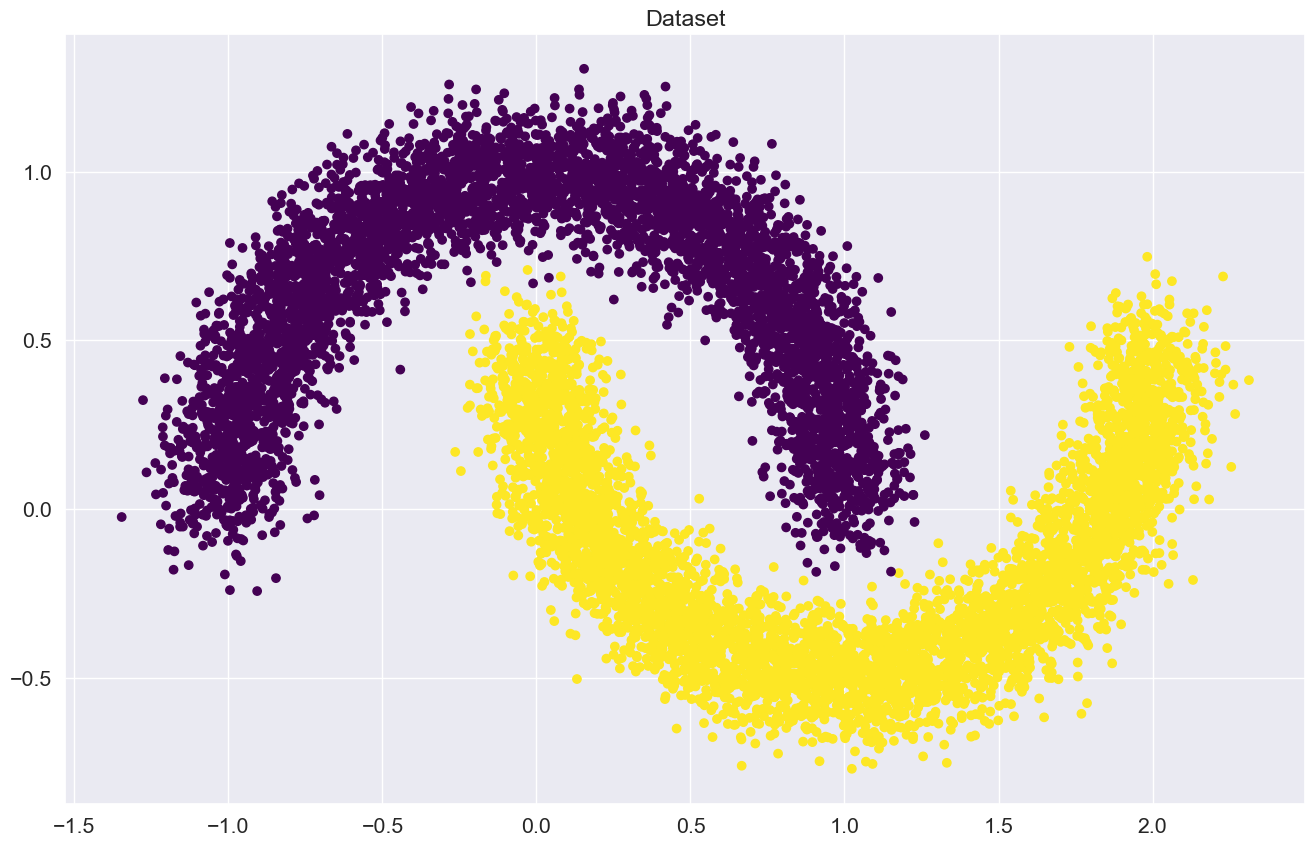

In [97]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [99]:

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)



Создаем `Dataset` и `DataLoader`. 

In [100]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [101]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x.view(-1)

In [102]:
a = torch.randn(1, 2)
b = torch.randn(128, 1)
print(a.size())
print(b.size())
# print(torch.matmul(a, b.view(2, 128)).size()[0])
print(b.view(-1).size())

torch.Size([1, 2])
torch.Size([128, 1])
torch.Size([128])


In [103]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [104]:
params = linear_regression.parameters()

print(sum(p.numel() for p in params))

3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [105]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break


Iteration: 0
Batch accuracy: 0.6875
Iteration: 100
Batch accuracy: 0.8828125
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 4

### Визуализируем результаты

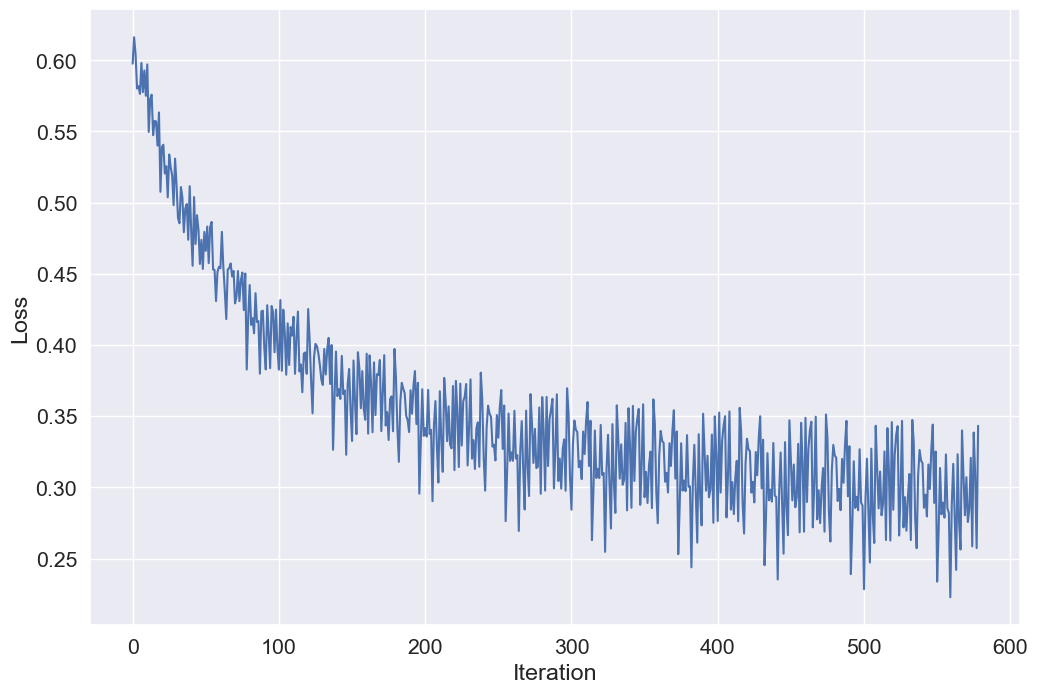

In [106]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

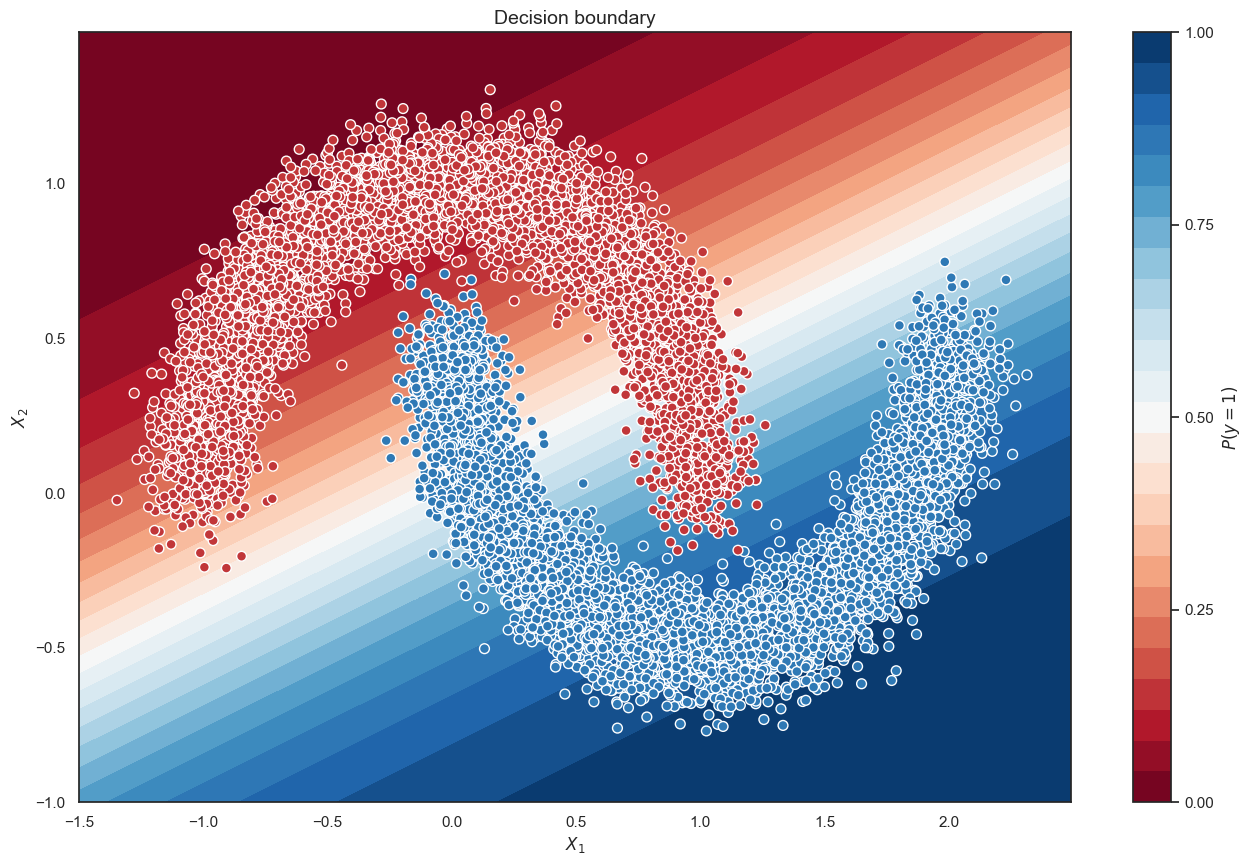

In [107]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:, 0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [108]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probs = torch.sigmoid(linear_regression.forward(x_batch))
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [109]:
from sklearn.metrics import accuracy_score

predicts = predict(val_dataloader, linear_regression)
print("Accuracy:", accuracy_score(y_val, predicts))  # YOUR CODE. Compute total accuracy

Accuracy: 0.8748


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.868

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [110]:
import os
import torchvision.transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [111]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [112]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [113]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [115]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)

            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8811431623931624
Loader: valid. Accuracy: 0.9284855769230769
Epoch: 2
Loader: train. Accuracy: 0.941940438034188
Loader: valid. Accuracy: 0.9529246794871795
Epoch: 3
Loader: train. Accuracy: 0.9598524305555556
Loader: valid. Accuracy: 0.9624399038461539
Epoch: 4
Loader: train. Accuracy: 0.9682491987179487
Loader: valid. Accuracy: 0.9667467948717948
Epoch: 5
Loader: train. Accuracy: 0.9741419604700855
Loader: valid. Accuracy: 0.9691506410256411
Epoch: 6
Loader: train. Accuracy: 0.9785490117521367
Loader: valid. Accuracy: 0.967948717948718
Epoch: 7
Loader: train. Accuracy: 0.9825220352564102
Loader: valid. Accuracy: 0.964042467948718
Epoch: 8
Loader: train. Accuracy: 0.9846087072649573
Loader: valid. Accuracy: 0.9666466346153846
Epoch: 9
Loader: train. Accuracy: 0.9862446581196581
Loader: valid. Accuracy: 0.9708533653846154
Epoch: 10
Loader: train. Accuracy: 0.9867120726495726
Loader: valid. Accuracy: 0.967948717948718


In [116]:
t = torch.tensor([[0.1, 0.7, 0.6, 0.5], [1, 2, 3, 4]])
print(t.argmax(-1))

tensor([1, 3])


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [117]:
elu_accuracy = accuracy["valid"]

In [118]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(f_activation):
    f_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        f_activation(),
        nn.Linear(128, 128),
        f_activation(),
        nn.Linear(128, 10))
    f_optimizer = torch.optim.Adam(f_model.parameters())
    f_accuracy = {"train": [], "valid": []}
    for EPOCH in range(10):
        for K, DATALOADER in loaders.items():
            f_epoch_correct = 0
            f_epoch_all = 0
            for x_batch_f, y_batch_f in DATALOADER:
                if K == "train":
                    f_model.train()
                    f_optimizer.zero_grad()
                    f_outp = f_model(x_batch_f)

                else:
                    f_model.eval()
                    with torch.no_grad():
                        f_outp = f_model(x_batch_f)

                f_preds = f_outp.argmax(-1)
                f_correct = (f_preds == y_batch_f).sum()
                f_all = len(y_batch_f)
                f_epoch_correct += f_correct.item()
                f_epoch_all += f_all
                if K == "train":
                    f_loss = criterion(f_outp, y_batch_f)
                    f_loss.backward()
                    f_optimizer.step()
            if K == "train":
                print(f"Epoch: {EPOCH + 1}")
            print(f"Loader: {K}. Accuracy: {f_epoch_correct / f_epoch_all}")
            f_accuracy[K].append(f_epoch_correct / f_epoch_all)
    return f_accuracy

In [119]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8648170405982906
Loader: valid. Accuracy: 0.8895232371794872
Epoch: 2
Loader: train. Accuracy: 0.8965010683760684
Loader: valid. Accuracy: 0.8986378205128205
Epoch: 3
Loader: train. Accuracy: 0.9002403846153846
Loader: valid. Accuracy: 0.8971354166666666
Epoch: 4
Loader: train. Accuracy: 0.9027610844017094
Loader: valid. Accuracy: 0.9000400641025641
Epoch: 5
Loader: train. Accuracy: 0.9041466346153846
Loader: valid. Accuracy: 0.9008413461538461
Epoch: 6
Loader: train. Accuracy: 0.9050814636752137
Loader: valid. Accuracy: 0.9002403846153846
Epoch: 7
Loader: train. Accuracy: 0.9065671741452992
Loader: valid. Accuracy: 0.9003405448717948
Epoch: 8
Loader: train. Accuracy: 0.9078692574786325
Loader: valid. Accuracy: 0.9011418269230769
Epoch: 9
Loader: train. Accuracy: 0.9091379540598291
Loader: valid. Accuracy: 0.9024439102564102
Epoch: 10
Loader: train. Accuracy: 0.9101729433760684
Loader: valid. Accuracy: 0.9035456730769231
Epoch: 1
Loader: train. Accur

In [120]:
plain_accuracy

{'train': [0.8648170405982906,
  0.8965010683760684,
  0.9002403846153846,
  0.9027610844017094,
  0.9041466346153846,
  0.9050814636752137,
  0.9065671741452992,
  0.9078692574786325,
  0.9091379540598291,
  0.9101729433760684],
 'valid': [0.8895232371794872,
  0.8986378205128205,
  0.8971354166666666,
  0.9000400641025641,
  0.9008413461538461,
  0.9002403846153846,
  0.9003405448717948,
  0.9011418269230769,
  0.9024439102564102,
  0.9035456730769231]}

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

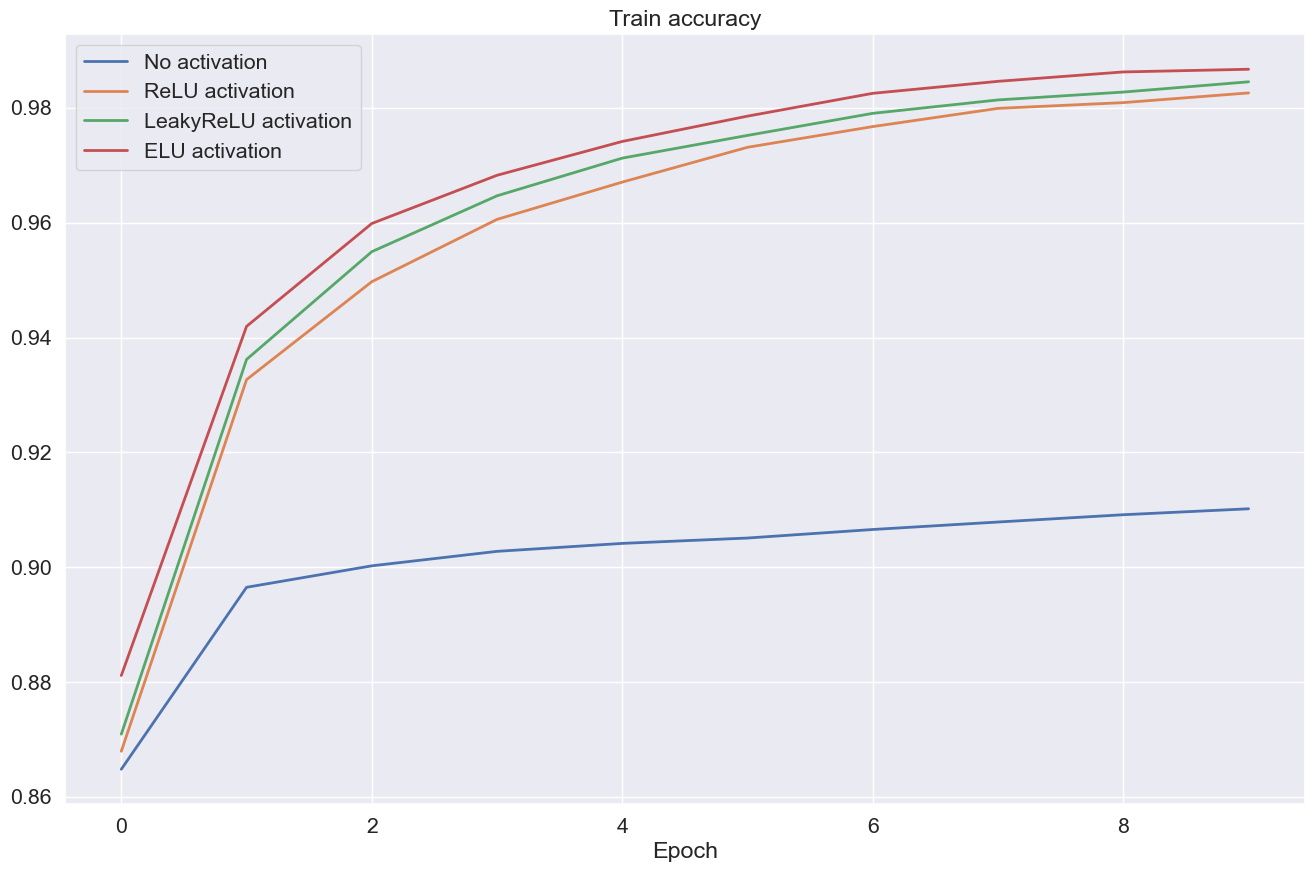

In [121]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Train accuracy")
plt.plot(range(max_epochs), plain_accuracy['train'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['train'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['train'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), accuracy['train'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

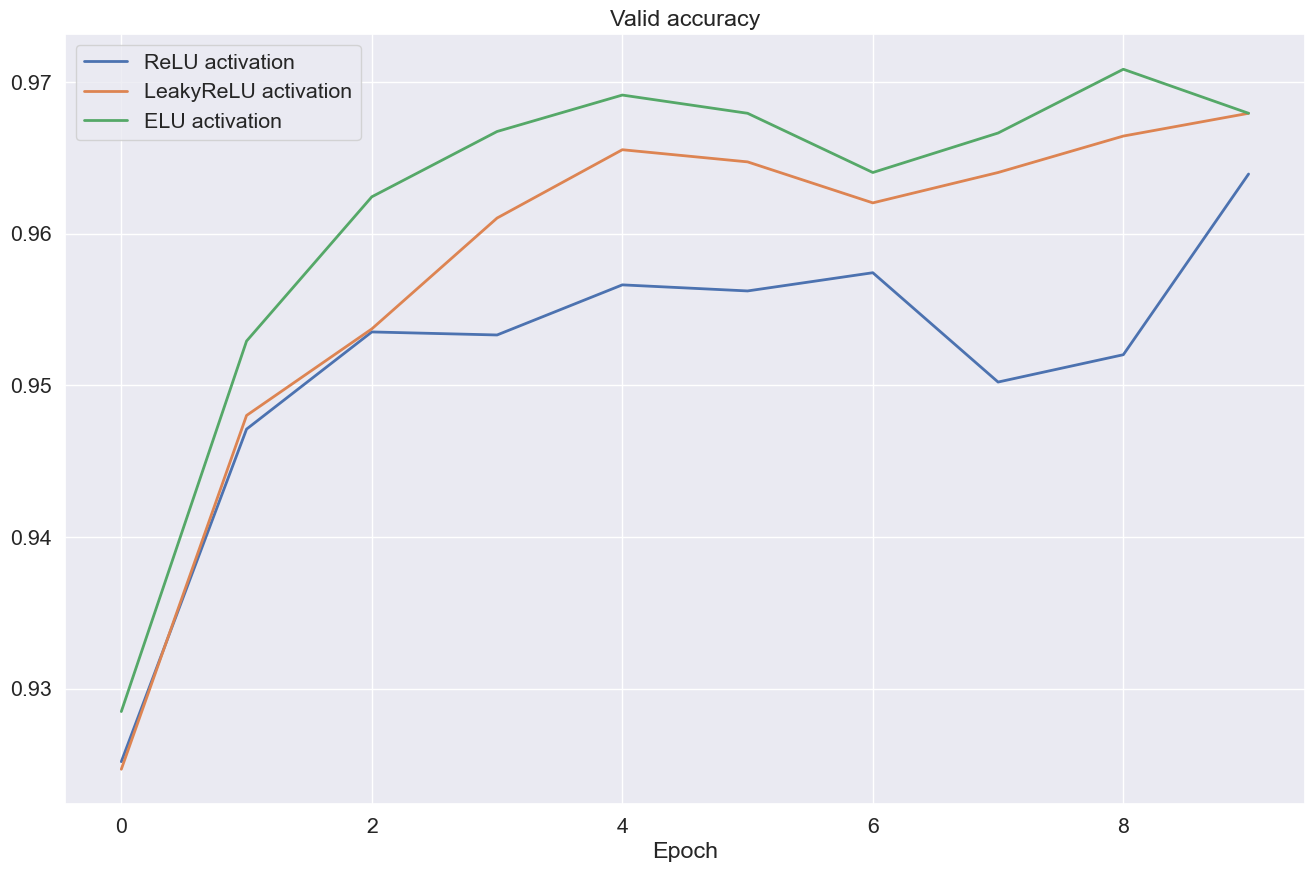

In [122]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Elu, если речь идёт о валидационной выборке.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [123]:
!curl https: // img.the-village.kz / the-village.com.kz / post-cover / 5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

curl: Failed to extract a sensible file name from the URL to use for storage!
curl: (3) URL using bad/illegal format or missing URL


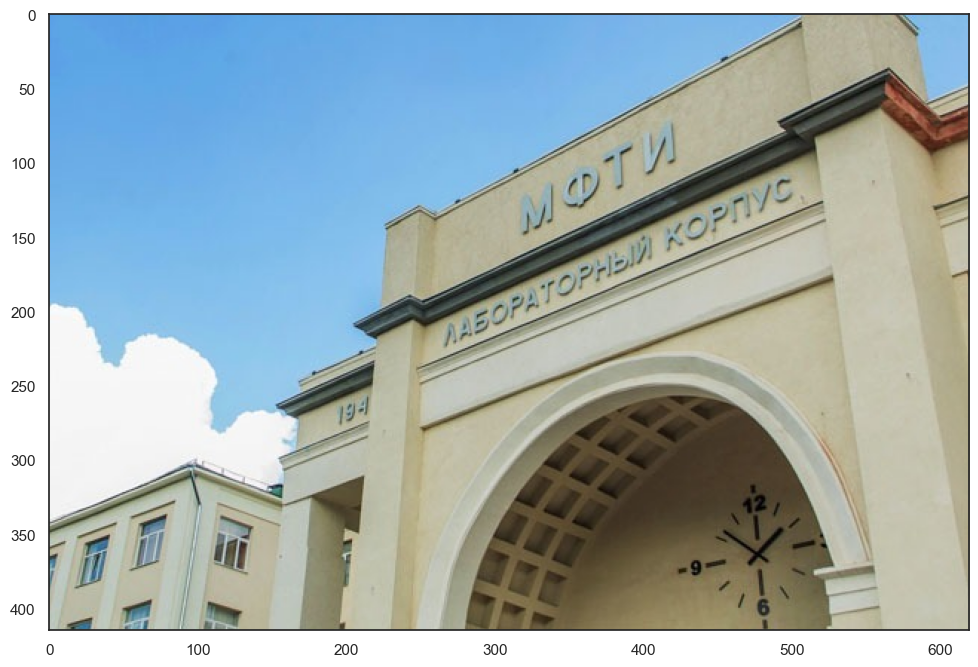

In [124]:
import cv2

sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [125]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

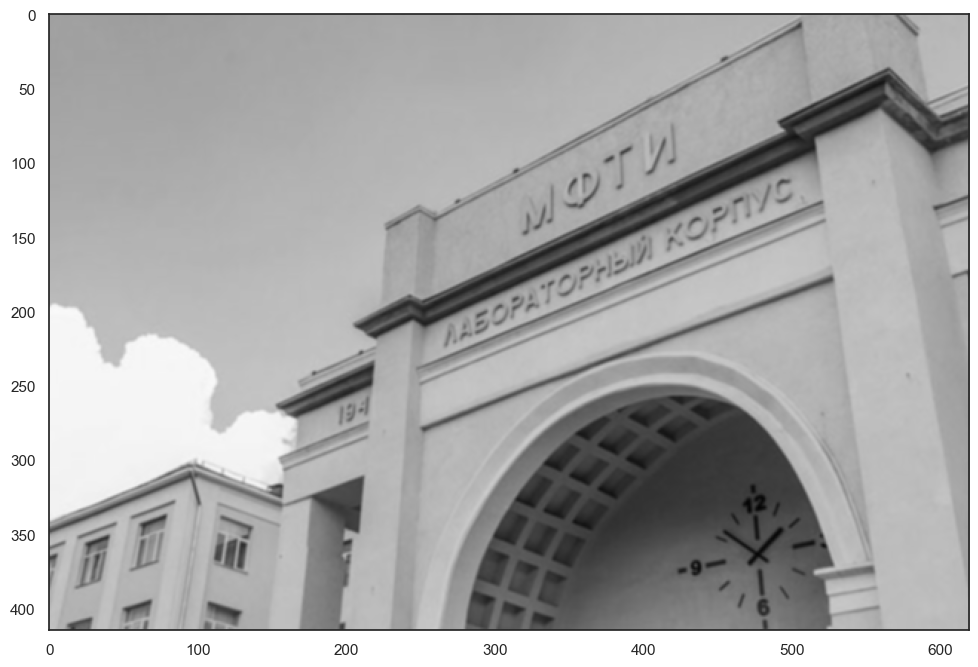

In [126]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
a - 3
б - 5
в - 4
г - 6
д - 2
е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [127]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, stride=1)
        self.fc1 = nn.Linear(22 * 22 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x

In [128]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [130]:
accuracy={"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == 'train':
                model.train()
                optimizer.zero_grad()
                out = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    out = model(x_batch)
            preds = out.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(out, y_batch)
                loss.backward()
                optimizer.step()

        accuracy[k].append(epoch_correct / epoch_all)




In [131]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

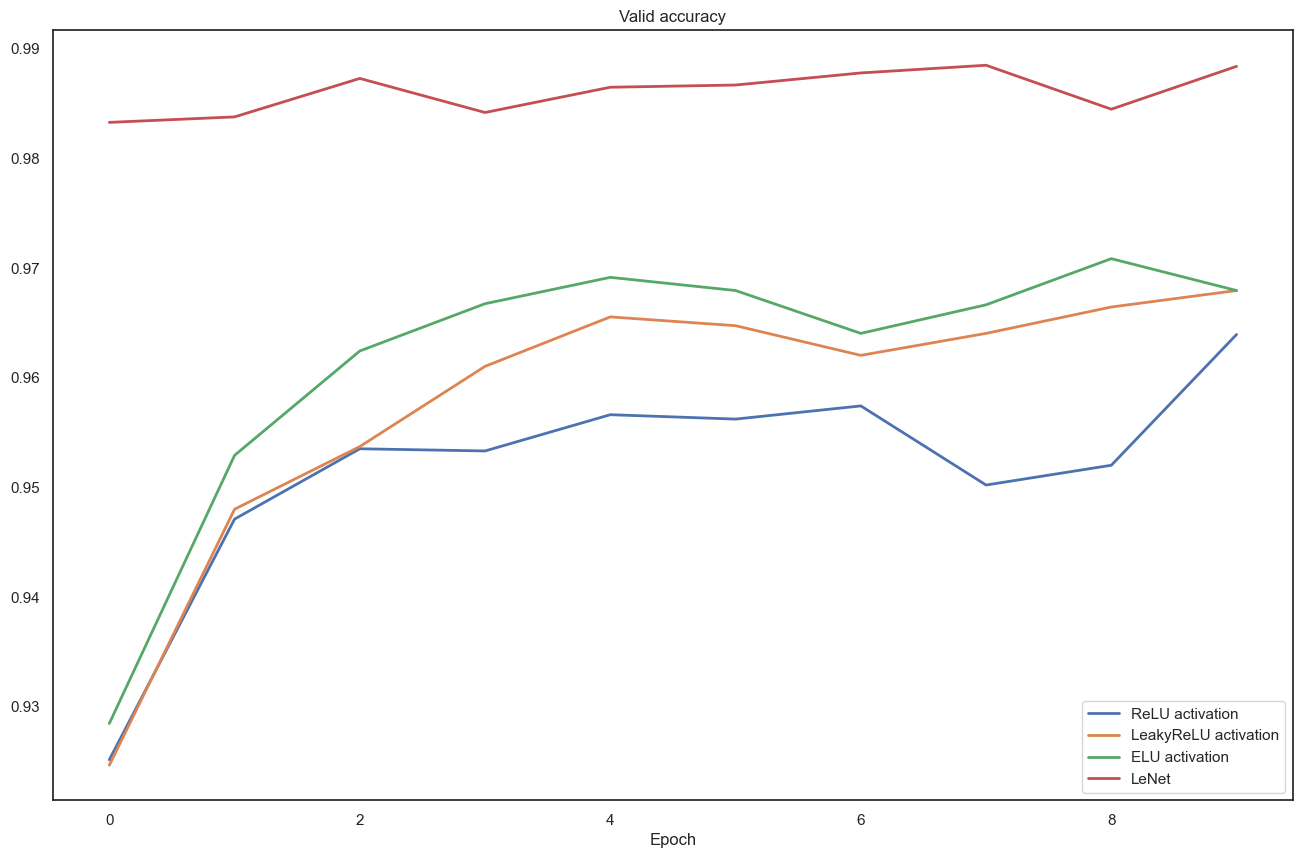

In [132]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [133]:
lenet_accuracy

[0.9832732371794872,
 0.9837740384615384,
 0.9872796474358975,
 0.9841746794871795,
 0.9864783653846154,
 0.9866786858974359,
 0.9877804487179487,
 0.9884815705128205,
 0.9844751602564102,
 0.9883814102564102]

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,988